# Nonparametric quantification of uncertainty of text classification models using conformal prediction

## Dataset

### Loading

In [1]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset('amazon_polarity')

smaller_dataset = dataset
smaller_dataset["train"] = smaller_dataset["train"].filter(lambda e, i: i<18000, with_indices=True)
smaller_dataset["test"] = smaller_dataset["test"].filter(lambda e, i: i<2000, with_indices=True)

Reusing dataset amazon_polarity (/Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-4b306cf1dbcb64cf.arrow
Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-6ebf23bc9117a57e.arrow


### BERT Tokenizer

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

In [3]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
smaller_tokenized_dataset = smaller_dataset.map(preprocess_function, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-d0bb4a3ae0dd4ec0.arrow


### Word embeddings

In [4]:
from gensim.models import KeyedVectors

model_word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [5]:
import nltk
from nltk.corpus import stopwords

def preprocess(sentence):
    nltk.word_tokenize(sentence)
    sentence = [word for word in sentence if word not in stopwords.words('english')]
    sentence = [model_word_vectors.get_vector(w) for w in sentence if w in model_word_vectors.key_to_index]
    return np.stack(sentence, axis=0).mean(0).reshape(300,) if len(sentence) > 0 else np.zeros(300,)

In [6]:
from tqdm import tqdm
import pandas as pd
from pandarallel import pandarallel
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

X_train_word_embeddings = np.stack(pd.Series(smaller_dataset["train"]["title"]).parallel_apply(lambda x: preprocess(x)).values, axis=0)
y_train_word_embeddings = np.array(smaller_dataset["train"]["label"])

X_test_word_embeddings = np.stack(pd.Series(smaller_dataset["test"]["title"]).parallel_apply(lambda x: preprocess(x)).values, axis=0)
y_test_word_embeddings = np.array(smaller_dataset["test"]["label"])

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Models

### BERT

In [7]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [8]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=smaller_tokenized_dataset["train"],
    eval_dataset=smaller_tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running training *****
  Num examples = 18000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5625


Step,Training Loss
500,0.414400
1000,0.348900
1500,0.276600
2000,0.255800
2500,0.212800
3000,0.183700
3500,0.154700
4000,0.130600
4500,0.123800
5000,0.089400


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_toke

TrainOutput(global_step=5625, training_loss=0.20477994571261937, metrics={'train_runtime': 7211.0674, 'train_samples_per_second': 12.481, 'train_steps_per_second': 0.78, 'total_flos': 384180293739648.0, 'train_loss': 0.20477994571261937, 'epoch': 5.0})

In [9]:
import torch
predicted = trainer.predict(smaller_tokenized_dataset["test"])

predicted_proba = torch.nn.functional.softmax(torch.tensor(predicted.predictions), dim=1)
data_bert = predicted_proba[:,1].numpy(), np.array(smaller_tokenized_dataset["test"]["label"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


<AxesSubplot:ylabel='Count'>

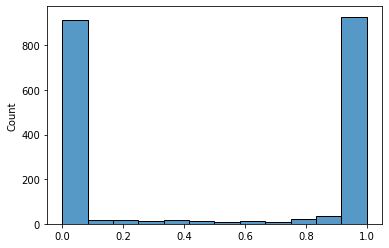

In [10]:
import seaborn as sns
sns.histplot(data_bert[0])

### SVM

In [11]:
from sklearn import svm
from sklearn.ensemble import BaggingClassifier

n_estimators = 4
model_svm = BaggingClassifier(svm.SVC(probability=True), max_samples=1.0 / n_estimators, n_jobs=-1)
model_svm.fit(X_train_word_embeddings, y_train_word_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

BaggingClassifier(base_estimator=SVC(probability=True), max_samples=0.25,
                  n_jobs=-1)

In [12]:
data_svm = model_svm.predict_proba(X_test_word_embeddings)[:,1], np.array(y_test_word_embeddings)

<AxesSubplot:ylabel='Count'>

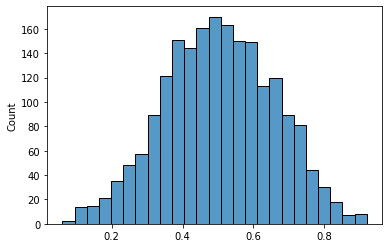

In [13]:
import seaborn as sns
sns.histplot(data_svm[0])

### LightGBM

In [14]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_word_embeddings, y_train_word_embeddings)

LGBMClassifier()

In [15]:
data_lgb = model_lgb.predict_proba(X_test_word_embeddings)[:,1], np.array(y_test_word_embeddings)

<AxesSubplot:ylabel='Count'>

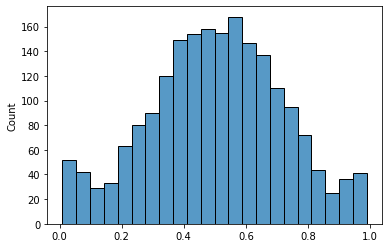

In [16]:
import seaborn as sns
sns.histplot(data_lgb[0])

## Evaluation

**Supporting code**

In [17]:
import VennAbers
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt

def plot_venn_abers(data):
    venn_abers = VennAbers.venn_abers_fast(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.3)
    plt.axis((0, 1, 0, 1))

def plot_isotonic_regression(data):
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba)
    plt.axis((0, 1, 0, 1))
    
def plot_all(data):
    venn_abers = VennAbers.venn_abers_fast(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(10,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.15)
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba, linestyle='dotted')
    plt.axis((0, 1, 0, 1))
    
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)
    
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend(["Venn-Abers", "Venn-Abers Interval", "Isotonic Regression"])

### BERT

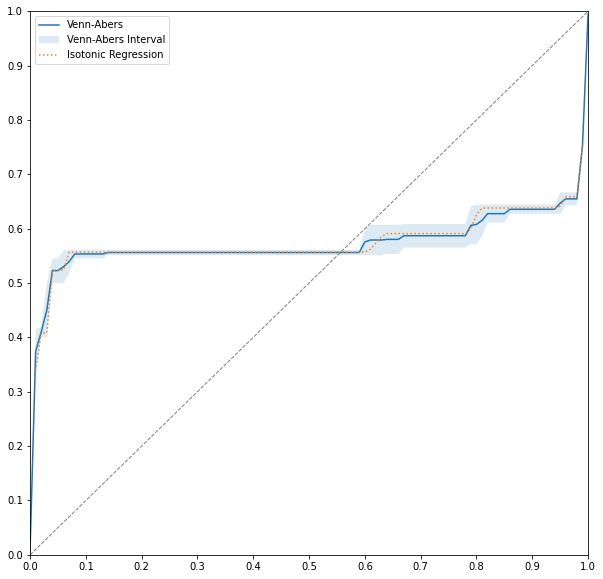

In [18]:
plot_all(data_bert)

### SVM

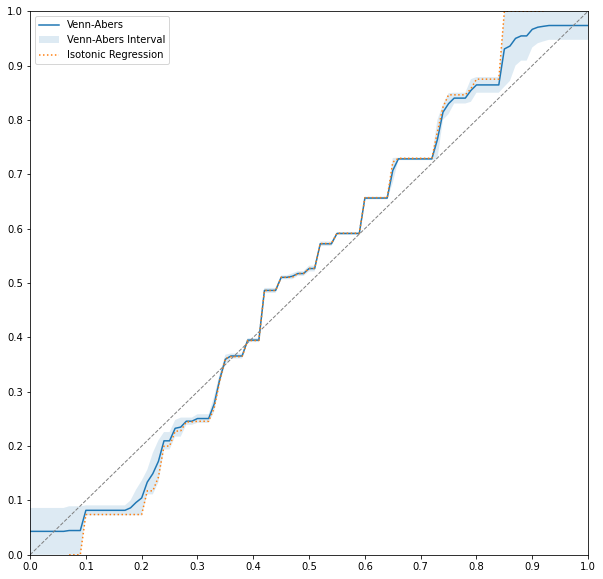

In [19]:
plot_all(data_svm)

### LightGBM

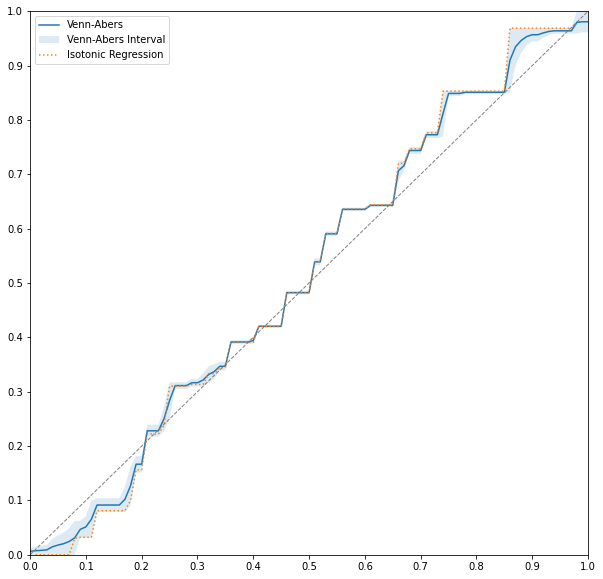

In [20]:
plot_all(data_lgb)

## Time evaluation

In [21]:
import time
from tqdm import tqdm
data_time_eval = data_lgb

In [22]:
def time_eval_slow(rounds=100):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        for s_x_test in (np.array(list(range(0, 101, 1))) / 100):
            venn_abers = VennAbers.venn_abers(list(zip(data_time_eval[0], data_time_eval[1])), s_x_test)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [23]:
def time_eval_fast(rounds=100):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        venn_abers = VennAbers.venn_abers_fast(list(zip(data_time_eval[0], data_time_eval[1])), np.array(list(range(0, 101, 1))) / 100)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [25]:
time_slow, time_fast = time_eval_slow(), time_eval_fast()
print(f"Slow Venn-Abers (avg. - 100 runs): {round(time_slow)} ms")
print(f"Fast Venn-Abers (avg. - 100 runs): {round(time_fast)} ms")
print(f"Average speed-up of {round(1 / ((time_slow-time_fast) / time_slow), 1)}x (100 runs)")

Slow Venn-Abers (avg. - 100 runs): 148 ms
Fast Venn-Abers (avg. - 100 runs): 80 ms
Average speed-up of 2.2x (100 runs)
